# Importações


In [42]:
import urllib
from itertools import product
from os import getenv
from sqlalchemy import create_engine
from dotenv import load_dotenv

import numpy as np
import pandas as pd
from datetime import datetime, timedelta, time
import plotly.graph_objects as go
import plotly.express as px
from fuzzywuzzy import process

# Connection


connection.py


In [43]:
# cSpell: disable=invalid-name
load_dotenv()


class Connection:
    """
    Class Connection
    """

    def __init__(self):
        """
        Constructor

        Args:
            user (str): user
            password (str): password
            database (str): database
            driver (str): driver
            server (str): server

        Usage:
            >>> from connection import Connection
            >>> connection = Connection()
            >>> connection.get_connection()
        """
        self.__user = getenv("PYMSSQL_USER")
        self.__password = getenv("PYMSSQL_PASSWORD")
        self.__database = getenv("PYMSSQL_DATABASE_AUTOMACAO")
        self.__driver = "{ODBC Driver 17 for SQL Server}"
        self.__server = getenv("PYMSSQL_SERVER")

    def get_connection_automacao(self):
        """
        Get connection

        Returns:
            object: connection

        Usage:
            >>> from connection import Connection
            >>> connection = Connection()
            >>> connection.get_connection()
        """
        try:
            params = urllib.parse.quote_plus(
                f"DRIVER={self.__driver};"
                f"SERVER={self.__server};"
                f"DATABASE={self.__database};"
                f"UID={self.__user};"
                f"PWD={self.__password};"
            )
            # pylint: disable=consider-using-f-string
            conexao_automacao = create_engine(
                "mssql+pyodbc:///?odbc_connect=%s" % params
            )
            return conexao_automacao
        # pylint: disable=broad-except
        except Exception as error:
            print(f"Error: {error}")
            return None

db_read.py


In [44]:
# cSpell: disable=invalid-name
class Read(Connection):
    """
    Class Read
    Read data from the database and return a pandas dataframe
    Create query to be executed in the database
    """

    # pylint: disable=useless-super-delegation
    def __init__(self):
        """
        Constructor
        """
        super().__init__()

    def get_automacao_data(self, query: str) -> pd.DataFrame:
        """
        Get data from database AUTOMACAO and return a pandas dataframe.

        Parameters
        ----------
        query : str
            Query to be executed in the database

        Returns
        -------
        pandas dataframe
            Dataframe with the query result
        """
        try:
            connection = self.get_connection_automacao()
            data = pd.read_sql(query, connection)
            return data
        # pylint: disable=broad-except
        except Exception as error:
            print(f"Error: {error}")
            return None

    def create_automacao_query(
        self, table: str, where: str = None, orderby: str = None
    ) -> str:
        """
        Create query to be executed in the database AUTOMACAO.

        Parameters
        ----------
        table : str
            Table name
        where : str
            Where clause (optional)
        orderby : str
            Order by clause (optional)

        Returns
        -------
        str
            Query to be executed in the database
        """
        query = f"SELECT * FROM AUTOMACAO.dbo.{table}"

        if where:
            query += f" WHERE {where}"

        if orderby:
            query += f" ORDER BY {orderby}"

        return query

## Criando a query e recebendo dados do Banco de Dados


In [45]:
# cSpell: disable=invalid-name
# Dia de hoje para uso no gráfico
now = pd.to_datetime("today")
today = now.strftime("%Y-%m-%d")

# Encontrando primeiro e último dia do mês anterior
first_day_this_month = now.replace(day=1)  # primeiro dia do mês atual
last_day_month = first_day_this_month - timedelta(
    days=1
)  # último dia do mês anterior
first_day_month = last_day_month.replace(day=1)  # primeiro dia do mês anterior

# mantendo o formato de data e removendo o horário
last_day_month = last_day_month.strftime("%Y-%m-%d")
first_day_month = first_day_month.strftime("%Y-%m-%d")
first_day_this_month = first_day_this_month.strftime("%Y-%m-%d")

print(f"Primeiro dia do mês anterior: {first_day_month}")
print(f"Último dia do mês anterior: {last_day_month}")
print(f"Primeiro dia do mês atual: {first_day_this_month}")

# Instancia a classe Read
DB_read = Read()

# Query para obter os dados do mês anterior
query_occ = DB_read.create_automacao_query(
    table="maquina_ocorrencia",
    where=f"data_registro >= '{first_day_this_month}'",
)

query_info = DB_read.create_automacao_query(
    table="maquina_info", where=f"data_registro >= '{first_day_this_month}'"
)

query_maq_cadastro = DB_read.create_automacao_query(
    table="maquina_cadastro",
    orderby="linha, data_registro DESC, hora_registro DESC",
)

# Leitura do Banco de Dados
df_occ = DB_read.get_automacao_data(query_occ)
df_info = DB_read.get_automacao_data(query_info)
df_maq_cadastro = DB_read.get_automacao_data(query_maq_cadastro)

# df_occ.to_html("teste.html")

Primeiro dia do mês anterior: 2023-12-01
Último dia do mês anterior: 2023-12-31
Primeiro dia do mês atual: 2024-01-01


Testes de Saída do Banco de Dados


In [46]:
df_occ

,recno,maquina_id,motivo_id,problema,solucao,data_registro,hora_registro,usuario_id
0,2638,TMF006,12,,,2024-01-02,01:16:52,000453
1,2639,TMF013,08,,,2024-01-02,01:17:04,000453
2,2640,TMF010,08,,,2024-01-02,01:17:20,000453
3,2641,TMF010,12,,,2024-01-02,01:18:45,000453
4,2642,TMF006,12,,,2024-01-03,08:14:58,000807
...,...,...,...,...,...,...,...,...
530,3168,TMF010,03,,,2024-01-23,11:28:59,000807
531,3169,TMF010,12,,,2024-01-23,12:57:42,000807
532,3170,TMF001,08,Recheando fora de posição,,2024-01-23,14:02:59,000838
533,3171,TMF015,08,Robô travou,,2024-01-23,14:04:08,000838


In [47]:
df_info

,recno,maquina_id,status,ciclo_1_min,ciclo_15_min,contagem_total_ciclos,contagem_total_produzido,turno,data_registro,hora_registro,tempo_parada,tempo_rodando
0,667577,TMF005,false,0.0,0.0,0.0,0.0,VES,2024-01-01,00:00:14.246666,0.0,0.0
1,667578,TMF002,false,0.0,0.0,0.0,0.0,VES,2024-01-01,00:00:15.253333,0.0,0.0
2,667579,TMF015,false,0.0,0.0,0.0,0.0,VES,2024-01-01,00:00:16.253333,0.0,0.0
3,667580,TMF011,false,0.0,0.0,0.0,0.0,VES,2024-01-01,00:00:17.253333,0.0,0.0
4,667581,TMF014,false,0.0,0.0,0.0,0.0,VES,2024-01-01,00:00:18.253333,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
219716,887293,TMF006,false,0.0,0.0,0.0,0.0,VES,2024-01-23,16:14:07.216666,0.0,0.0
219717,887294,TMF013,true,7.0,104.0,192.0,186.0,VES,2024-01-23,16:14:08.216666,0.0,0.0
219718,887295,TMF012,false,0.0,0.0,0.0,0.0,VES,2024-01-23,16:14:09.216666,0.0,0.0
219719,887296,TMF007,true,11.0,150.0,278.0,270.0,VES,2024-01-23,16:14:10.216666,0.0,0.0


In [48]:
df_maq_cadastro

,recno,maquina_id,fabrica,linha,data_registro,hora_registro,usuario_id
0,57,TMF008,,0,2024-01-20,09:44:36,000264
1,55,TMF001,,0,2024-01-14,16:13:05,000264
2,51,TMF003,,0,2023-11-11,12:41:46,000264
3,48,TMF005,,0,2023-11-11,12:37:43,000264
4,47,TMF014,,0,2023-10-29,11:44:53,000264
5,43,TMF005,,0,2023-10-22,12:32:23,000264
6,42,TMF014,,0,2023-10-14,14:58:15,000264
7,39,TMF005,0,0,2023-10-06,15:53:45,000264
8,38,TMF003,,0,2023-10-02,08:17:14,002131
9,37,TMF003,,0,2023-09-30,16:35:54,000264


# Service


clean_data.py


In [49]:
# cSpell: disable=invalid-name
class CleanData:

    """

    Classe para limpeza dos dados



    Atributos:

        df (pd.DataFrame): Dataframe com os dados a serem limpos



    Métodos:

        clean_maq_cadastro: Limpa os dados de cadastro das máquinas



    """

    def __init__(self):
        pass

    def clean_maq_cadastro(self, cadastro: pd.DataFrame) -> pd.DataFrame:
        """

        Limpa os dados de cadastro das máquinas



        Args:

        -----

            data (pd.DataFrame): Dataframe com os dados a serem limpos



        Retorna:

        --------

            pd.DataFrame: Dataframe com os dados limpos



        Exemplo:

        --------



            >>> from app.service.clean_data import CleanData

            >>> import pandas as pd

            >>> df = pd.DataFrame({'maquina_id': [TMF001, TMF002, TMF003], 'linha': [1, 2, 3],

            'fabrica': [1, 2, 2], 'data_registro': ['2021-01-01', '2021-01-01', '2021-01-01'],

            'hora_registro': ['00:00:00.000', '00:00:00.000', '00:00:00.000'], 'recno': [1, 2, 3],

            usuario_id: [00532, 00533, 00534]})

            >>> clean_data = CleanData()

            >>> df_clean = clean_data.clean_maq_cadastro(df)

            >>> df_clean

                maquina_id  linha  fabrica data_hora_registro       usuario_id

            0     TMF001      1        1    2021-01-01 00:00:00      532

            1     TMF002      2        2    2021-01-01 00:00:00      533

            2     TMF003      3        2    2021-01-01 00:00:00      534





        """

        # Remover rows onde a linha é 0

        # df_cadastro = cadastro[cadastro["linha"] != 0]
        df_cadastro = cadastro.copy()

        # Remover linhas duplicadas (erros de cadastro)

        df_cadastro = df_cadastro.drop_duplicates(
            subset=["data_registro", "linha"], keep="first"
        )

        # Criar nova coluna combinando data e hora

        df_cadastro["data_hora_registro"] = (
            df_cadastro["data_registro"].astype(str)
            + " "
            + df_cadastro["hora_registro"].astype(str).str.split(".").str[0]
        )

        # Converter coluna data_hora_registro para datetime

        df_cadastro["data_hora_registro"] = pd.to_datetime(
            df_cadastro["data_hora_registro"], format="%Y-%m-%d %H:%M:%S"
        )

        # Remover colunas desnecessárias

        df_cadastro = df_cadastro.drop(
            columns=["recno", "data_registro", "hora_registro"]
        )

        # Ordenar dataframe para facilitar trabalho futuro

        df_cadastro = df_cadastro.sort_values(
            by=["maquina_id", "data_hora_registro"], ascending=[True, False]
        )

        # reiniciar o index

        df_cadastro = df_cadastro.reset_index(drop=True)

        return df_cadastro

    def maq_info(self, info: pd.DataFrame) -> pd.DataFrame:
        """

        Limpa os dados de cadastro das máquinas



        Args:

        -----

            data (pd.DataFrame): Dataframe com os dados a serem limpos



        Retorna:

        --------

            pd.DataFrame: Dataframe com os dados limpos



        Exemplo:

        --------



            >>> from app.service.clean_data import CleanData

            >>> import pandas as pd

            >>> df = pd.DataFrame({'maquina_id': [TMF001, TMF002, TMF003], 'status'[False, True, True], 'turno'[MAT, VES, NOT], 'data_registro': ['2021-01-01', '2021-01-01', '2021-01-01'],

            'hora_registro': ['00:00:00.000', '00:00:00.000', '00:00:00.000'], 'recno': [1, 2, 3],

            })

            >>> clean_data = CleanData()

            >>> df_clean = clean_data.clean_maq_info(df)

            >>> df_clean

                maquina_id  status  turno   data_hora_registro      data_hora_final         tempo_registro_min

            0     TMF001    parada    MAT   2021-01-01 00:00:00     2021-01-01 00:01:00     480

            1     TMF002    rodando   VES   2021-01-01 00:00:00     2021-01-01 00:01:00     10

            2     TMF003    rodando   NOT   2021-01-01 00:00:00     2021-01-01 00:01:00     10



        """

        # Ordenar por maquina_id e data_registro, hora_registro
        df_info = info.sort_values(
            by=["maquina_id", "data_registro", "hora_registro", "turno"],
        )

        # Criar nova coluna combinando data e hora
        df_info["data_hora_registro"] = (
            df_info["data_registro"].astype(str)
            + " "
            + df_info["hora_registro"].astype(str).str.split(".").str[0]
        )

        # Reordenar colunas (descarta desnecessárias)
        df_info = df_info[
            [
                "maquina_id",
                "status",
                "turno",
                "data_hora_registro",
                "contagem_total_ciclos",
                "contagem_total_produzido",
            ]
        ]

        # Se for a primeira linha de cada máquina e o turno for VES, alterar para NOT
        df_info.loc[
            (df_info["turno"] == "VES")
            & (df_info["maquina_id"] != df_info["maquina_id"].shift()),
            "turno",
        ] = "NOT"

        # Se for a primeira linha de cada dia e o turno for VES, data_hora_registro para o dia anterior às 23:59:59
        df_info["data_hora_registro"] = pd.to_datetime(
            df_info["data_hora_registro"]
        )
        df_info.loc[
            (df_info["turno"] == "VES")
            & (
                df_info["data_hora_registro"]
                != df_info["data_hora_registro"].shift()
            )
            & (df_info["data_hora_registro"].dt.time > time(0, 0, 0))
            & (df_info["data_hora_registro"].dt.time < time(0, 5, 0)),
            "data_hora_registro",
        ] = (
            df_info["data_hora_registro"] - pd.Timedelta(days=1)
        ).dt.normalize() + pd.Timedelta(
            hours=23, minutes=59, seconds=59
        )
        # normalize para remover a hora da data(na verdade deixa 00:00:00) e timedelta para adicionar/alterar 23:59:59

        # Criar nova coluna status_change para identificar mudança de status
        df_info["status_change"] = df_info["status"].ne(
            df_info["status"].shift()
        )

        # Criar coluna para identificar a mudança de máquina
        df_info["maquina_change"] = df_info["maquina_id"].ne(
            df_info["maquina_id"].shift()
        )

        # Criar coluna para identificar a mudança de turno
        df_info["turno_change"] = df_info["turno"].ne(df_info["turno"].shift())

        # Atualizar coluna change para incluir mudança de turno
        df_info["change"] = (
            df_info["status_change"]
            | df_info["maquina_change"]
            | df_info["turno_change"]
        )

        # Agrupar por maquina e identificar data e hora da última mudança de status
        df_info["change_time"] = (
            df_info.groupby("maquina_id")["data_hora_registro"]
            .shift(0)
            .where(df_info["change"])
        )

        # Feito para agrupar por maquina_id e turno e manter o ultimo registro de cada grupo
        df_info = (
            df_info.groupby(["maquina_id", "change_time"])
            .agg(
                status_first=("status", "first"),
                turno_first=("turno", "first"),
                data_hora_registro_first=("data_hora_registro", "first"),
                contagem_total_ciclos_last=("contagem_total_ciclos", "last"),
                contagem_total_produzido_last=(
                    "contagem_total_produzido",
                    "last",
                ),
                change_first=("change", "first"),
                maquina_change_first=("maquina_change", "first"),
            )
            .reset_index()
        )

        # Renomear colunas
        df_info.rename(
            columns={
                "status_first": "status",
                "turno_first": "turno",
                "data_hora_registro_first": "data_hora_registro",
                "contagem_total_ciclos_last": "contagem_total_ciclos",
                "contagem_total_produzido_last": "contagem_total_produzido",
                "change_first": "change",
                "maquina_change_first": "maquina_change",
            },
            inplace=True,
        )

        # Criar nova coluna com a data_hora_final do status
        df_info["data_hora_final"] = (
            df_info.groupby("maquina_id")["data_hora_registro"]
            .shift(-1)
            .where(~df_info["maquina_change"])
        )

        # Atualizar coluna data_hora_final onde maquina_change é True
        df_info.loc[df_info["maquina_change"], "data_hora_final"] = df_info[
            "change_time"
        ].shift(-1)

        # Remover colunas desnecessárias
        df_info.drop(
            columns=[
                "maquina_change",
                "change",
                "change_time",
            ],
            inplace=True,
        )

        # Remover linhas onde data_hora_final é nulo
        df_info.dropna(subset=["data_hora_final"], inplace=True)

        # Cria nova coluna tempo_registro_min para calcular o tempo de registro em minutos
        df_info["tempo_registro_min"] = (
            pd.to_datetime(df_info["data_hora_final"])
            - pd.to_datetime(df_info["data_hora_registro"])
        ).dt.total_seconds() / 60

        # Arredondar tempo_registro_min e converter para inteiro
        df_info["tempo_registro_min"] = (
            df_info["tempo_registro_min"].round(0).astype(int)
        )

        # Incluir um status in_test para os casos onde o status true permanece por menos de 10 minutos
        df_info = df_info.astype(
            {"status": str}
        )  # para evitar erros de comparação

        df_info.loc[
            (df_info["status"] == "true")
            & (df_info["tempo_registro_min"] < 10),
            "status",
        ] = "in_test"

        # Ajustar nomenclatura dos status
        df_info.loc[df_info["status"] == "true", "status"] = "rodando"
        df_info.loc[df_info["status"] == "false", "status"] = "parada"

        # Remover colunas desnecessárias
        df_info.drop(
            columns=[
                "contagem_total_ciclos",
                "contagem_total_produzido",
            ],
            inplace=True,
        )

        # Ajustar o index
        df_info.reset_index(drop=True, inplace=True)

        return df_info

    def get_stops_data(self, info: pd.DataFrame) -> pd.DataFrame:
        """

        Retorna um dataframe com os dados de paradas consolidados



        Args:

        -----

            df (pd.DataFrame): Dataframe com os dados de paradas



        Retorna:

        --------

            pd.DataFrame: Dataframe com os dados de paradas consolidados



        Exemplo:

        --------



            >>> from app.service.get_stops_data import GetStopsData

            >>> import pandas as pd

            >>> get_stops_data = GetStopsData()

            >>> df_stops = get_stops_data.get_stops_data(df)



        """

        # Copiar o dataframe

        df = info.copy()

        # Transformar data e hora em datetime

        df["data_hora_registro"] = pd.to_datetime(df["data_hora_registro"])

        df["data_hora_final"] = pd.to_datetime(df["data_hora_final"])

        # Ordenar por maquina_id, turno, data_hora_registro

        df.sort_values(
            by=["maquina_id", "turno", "data_hora_registro"], inplace=True
        )

        # Criar coluna data_hora_registro_turno para identificar onde está rodando

        df["rodando"] = df["status"] == "rodando"

        # Cria uma coluna grupo para identificar os grupos de paradas

        df["grupo"] = (
            (df["rodando"] != df["rodando"].shift())
            | (df["maquina_id"] != df["maquina_id"].shift())
            | (df["turno"] != df["turno"].shift())
            | (
                df["data_hora_registro"].dt.date
                != df["data_hora_registro"].shift().dt.date
            )
        )

        # Soma o tempo de parada por grupo

        df["grupo"] = df["grupo"].cumsum()

        # Agregar os dados por grupo

        df = (
            df.groupby("grupo")
            .agg(
                {
                    "maquina_id": "first",
                    "turno": "first",
                    "status": "first",
                    "tempo_registro_min": "sum",
                    "data_hora_registro": "first",
                    "data_hora_final": "last",
                }
            )
            .reset_index(drop=True)
        )

        # Ordenar por maquina_id, data_hora_registro

        df.sort_values(by=["maquina_id", "data_hora_registro"], inplace=True)

        # Substituir status in_test por parada

        df.loc[df["status"] == "in_test", "status"] = "parada"

        # Substituir valores nulos por np.nan

        df.fillna(np.nan, inplace=True)

        # Reiniciar o index

        df.reset_index(drop=True, inplace=True)

        return df

    def dayofweek_adjust(self, df: pd.DataFrame) -> pd.DataFrame:
        """

        Ajusta o dia da semana para incluir paradas programadas



        Args:

        -----

            df (pd.DataFrame): Dataframe com os dados de paradas



        Retorna:

        --------

            pd.DataFrame: Dataframe com os dados de paradas ajustados



        Exemplo:

        --------



            >>> from app.service.get_stops_data import GetStopsData

            >>> import pandas as pd

            >>> get_stops_data = GetStopsData()

            >>> df_stops = get_stops_data.dayofweek_adjust(df)



        """

        # Garantir que a coluna data_hora_registro é datetime

        df["data_hora_registro"] = pd.to_datetime(df["data_hora_registro"])

        # Identificar os domingos

        df["domingo"] = df["data_hora_registro"].dt.dayofweek == 6

        # Listar feriados

        feriados = pd.read_csv("../assets/feriados.csv")

        # Converter a coluna data para datetime

        feriados["feriados"] = pd.to_datetime(feriados["feriados"])

        # Identificar os feriados

        df["feriado"] = df["data_hora_registro"].dt.date.isin(
            feriados["feriados"].dt.date
        )

        # Identificar os dias após os feriados

        feriados["dia_apos_feriado"] = feriados["feriados"] + pd.Timedelta(
            days=1
        )

        df["dia_apos_feriado"] = df["data_hora_registro"].dt.date.isin(
            feriados["dia_apos_feriado"].dt.date
        )

        # Identificar sábados

        df["sabado"] = df["data_hora_registro"].dt.dayofweek == 5

        # Criar nova coluna unindo domingo, feriado e dia após feriado e descartar

        # as colunas domingo, feriado e dia após feriado

        df["domingo_feriado_emenda"] = (
            df["domingo"]
            | df["feriado"]
            | df["dia_apos_feriado"]
            | df["sabado"]
        )

        df.drop(
            columns=["domingo", "feriado", "dia_apos_feriado"], inplace=True
        )

        return df

    def clean_maq_info(self, info: pd.DataFrame) -> pd.DataFrame:
        """Agrupa funções de limpeza dos dados de info das máquinas para parada



        Args:

            info (pd.DataFrame): Info das máquinas do Banco de Dados



        Returns:

            pd.DataFrame: Dataframe com os dados limpos

        """

        df_info = info.copy()

        df_clean = self.maq_info(df_info)

        df_clean = self.get_stops_data(df_clean)

        df_clean = self.dayofweek_adjust(df_clean)

        return df_clean

    def clean_maq_occ(self, occ: pd.DataFrame) -> pd.DataFrame:
        """

        Limpa os dados de cadastro das máquinas



        Args:

        -----

            data (pd.DataFrame): Dataframe com os dados a serem limpos



        Retorna:

        --------

            pd.DataFrame: Dataframe com os dados limpos



        Exemplo:





        """

        # Motivos de Parada

        motivos = {
            1: "Ajustes",
            2: "Troca de Bobina",
            3: "Refeição",
            4: "Reunião",
            5: "Café e Ginástica Laboral",
            6: "Limpeza",
            7: "Manutenção Elétrica",
            8: "Manutenção Mecânica",
            9: "Material em Falta",
            10: "Setup de Sabor",
            11: "Setup de Tamanho",
            12: "Parada Programada",
            13: "Intervenção de Qualidade",
            14: "Linha Cheia",
            15: "Treinamento",
            16: "Limpeza Industrial",
        }

        # Modificar coluna motivo_id para int

        df_occ = occ.astype({"motivo_id": int})

        # Unir as colunas de data e hora

        df_occ["data_hora_registro"] = (
            df_occ["data_registro"].astype(str)
            + " "
            + df_occ["hora_registro"].astype(str).str.split(".").str[0]
        )

        # Criar coluna motivo_nome com base no dicionário motivos

        df_occ["motivo_nome"] = df_occ["motivo_id"].map(motivos)

        # Ajustar problema e solucao se a string estiver vazia

        df_occ["problema"] = df_occ["problema"].replace("", np.nan)

        df_occ["solucao"] = df_occ["solucao"].replace("", np.nan)

        # Se o problema for nulo, copiar o motivo_nome para o problema, exceto para os motivos 1, 7, 8, 9, 14,

        df_occ.loc[
            df_occ["problema"].isnull()
            & ~df_occ["motivo_id"].isin([1, 7, 8, 9, 14]),
            "problema",
        ] = df_occ["motivo_nome"]

        # Definir ordem das colunas

        df_occ = df_occ[
            [
                "maquina_id",
                "motivo_id",
                "motivo_nome",
                "problema",
                "solucao",
                "data_hora_registro",
                "usuario_id",
            ]
        ]

        return df_occ

    def clean_maq_info_prod(self, info: pd.DataFrame) -> pd.DataFrame:
        """

        Limpa os dados de info das máquinas para produção

        """

        # Ordenar por maquina_id asc, turno asc, data_registro desc, hora_registro desc

        df_info = info.sort_values(
            by=["maquina_id", "turno", "data_registro", "hora_registro"],
            ascending=[True, True, False, False],
        )

        # Agrupar por maquina_id e turno e manter o ultimo registro de cada grupo

        df_info = (
            df_info.groupby(["maquina_id", "turno", "data_registro"])
            .first()
            .reset_index()
        )

        # Criar nova coluna combinando data e hora

        df_info["data_hora_registro"] = (
            df_info["data_registro"].astype(str)
            + " "
            + df_info["hora_registro"].astype(str).str.split(".").str[0]
        )

        # Converter coluna data_hora_registro para datetime

        df_info["data_hora_registro"] = pd.to_datetime(
            df_info["data_hora_registro"], format="%Y-%m-%d %H:%M:%S"
        )

        # Se o turno for VES, e a hora de data_hora_registro for entre 00:00:00 e 00:01:00, alterar a data_registro para o dia anterior

        df_info.loc[
            (df_info["turno"] == "VES")
            & (time(0, 0, 0) < df_info["data_hora_registro"].dt.time)
            & (df_info["data_hora_registro"].dt.time < time(0, 5, 0)),
            "data_registro",
        ] = df_info["data_registro"] - pd.Timedelta(days=1)

        # Encontrar primeiro dia do mês atual

        first_day_this_month = pd.to_datetime("today").replace(day=1)

        # Remover datas do mês anterior

        df_info = df_info[
            df_info["data_registro"] >= first_day_this_month.date()
        ]

        # Remover duplicatas com base em 'maquina_id', 'turno' e 'data_registro', mantendo apenas a entrada com a 'data_hora_registro' mais recente

        df_info = df_info.drop_duplicates(
            subset=["maquina_id", "turno", "data_registro"], keep="last"
        )

        # Remover colunas desnecessárias

        df_info.drop(
            columns=[
                "recno",
                "status",
                "ciclo_1_min",
                "ciclo_15_min",
                "tempo_parada",
                "tempo_rodando",
                "hora_registro",
            ],
            inplace=True,
        )

        # Reiniciar o index

        df_info.reset_index(drop=True, inplace=True)

        return df_info

Saída de Limpeza do Cadastro


In [50]:
clean_data = CleanData()

df_maq_cadastro_clean = clean_data.clean_maq_cadastro(df_maq_cadastro)

df_maq_cadastro_clean

,maquina_id,fabrica,linha,usuario_id,data_hora_registro
0,TMF001,1,9,000264,2024-01-20 09:43:46
1,TMF001,,0,000264,2024-01-14 16:13:05
2,TMF001,1,8,002131,2023-09-25 10:45:38
3,TMF002,1,2,000264,2023-09-30 16:33:59
4,TMF003,1,8,000264,2024-01-14 16:12:44
5,TMF003,,0,000264,2023-11-11 12:41:46
6,TMF003,1,5,000264,2023-10-06 15:54:22
7,TMF003,,0,002131,2023-10-02 08:17:14
8,TMF003,,0,000264,2023-09-30 16:35:54
9,TMF003,1,2,001996,2023-09-23 15:24:20


Saída da Limpeza de Máquina Info com dados de paradas


In [51]:
df_maq_info_clean = clean_data.clean_maq_info(df_info)

df_maq_info_clean

,maquina_id,turno,status,tempo_registro_min,data_hora_registro,data_hora_final,sabado,domingo_feriado_emenda
0,TMF001,NOT,parada,482,2024-01-01 00:00:21,2024-01-01 08:02:22,False,True
1,TMF001,MAT,parada,480,2024-01-01 08:02:22,2024-01-01 16:02:24,False,True
2,TMF001,VES,parada,480,2024-01-01 16:02:24,2024-01-02 00:02:25,False,True
3,TMF001,NOT,parada,480,2024-01-02 00:02:25,2024-01-02 08:02:27,False,True
4,TMF001,MAT,parada,480,2024-01-02 08:02:27,2024-01-02 16:02:28,False,True
...,...,...,...,...,...,...,...,...
5807,TMF015,MAT,rodando,38,2024-01-23 13:46:57,2024-01-23 14:24:57,False,False
5808,TMF015,MAT,parada,18,2024-01-23 14:24:57,2024-01-23 14:42:57,False,False
5809,TMF015,MAT,rodando,60,2024-01-23 14:42:57,2024-01-23 15:42:57,False,False
5810,TMF015,MAT,parada,8,2024-01-23 15:42:57,2024-01-23 15:50:57,False,False


Saída da Limpeza das Ocorrências


In [52]:
df_maq_occ_clean = clean_data.clean_maq_occ(df_occ)

df_maq_occ_clean

,maquina_id,motivo_id,motivo_nome,problema,solucao,data_hora_registro,usuario_id
0,TMF006,12,Parada Programada,Parada Programada,NaN,2024-01-02 01:16:52,000453
1,TMF013,8,Manutenção Mecânica,NaN,NaN,2024-01-02 01:17:04,000453
2,TMF010,8,Manutenção Mecânica,NaN,NaN,2024-01-02 01:17:20,000453
3,TMF010,12,Parada Programada,Parada Programada,NaN,2024-01-02 01:18:45,000453
4,TMF006,12,Parada Programada,Parada Programada,NaN,2024-01-03 08:14:58,000807
...,...,...,...,...,...,...,...
530,TMF010,3,Refeição,Refeição,NaN,2024-01-23 11:28:59,000807
531,TMF010,12,Parada Programada,Parada Programada,NaN,2024-01-23 12:57:42,000807
532,TMF001,8,Manutenção Mecânica,Recheando fora de posição,NaN,2024-01-23 14:02:59,000838
533,TMF015,8,Manutenção Mecânica,Robô travou,NaN,2024-01-23 14:04:08,000838


Saída de limpeza de maquina info com dados de produção


In [53]:
df_maq_info_prod_clean = clean_data.clean_maq_info_prod(df_info)


df_maq_info_prod_clean

,maquina_id,turno,data_registro,contagem_total_ciclos,contagem_total_produzido,data_hora_registro
0,TMF001,MAT,2024-01-01,0.0,0.0,2024-01-01 16:00:24
1,TMF001,MAT,2024-01-02,0.0,0.0,2024-01-02 16:00:28
2,TMF001,MAT,2024-01-03,8148.0,8060.0,2024-01-03 16:00:32
3,TMF001,MAT,2024-01-04,9472.0,9374.0,2024-01-04 16:00:37
4,TMF001,MAT,2024-01-05,9632.0,9548.0,2024-01-05 16:00:41
...,...,...,...,...,...,...
940,TMF015,VES,2024-01-19,0.0,0.0,2024-01-19 23:58:40
941,TMF015,VES,2024-01-20,0.0,0.0,2024-01-20 23:58:46
942,TMF015,VES,2024-01-21,48.0,48.0,2024-01-21 23:58:50
943,TMF015,VES,2024-01-22,6198.0,6194.0,2024-01-22 23:58:54


## Unindo info e ocorrências


join_data.py


In [54]:
# cSpell: disable=invalid-name
class JoinData:

    """


    Classe para unir os dados de cadastro, info e ocorrência


    """

    def __init__(self):
        pass

    def join_info_occ(
        self, occ: pd.DataFrame, info: pd.DataFrame
    ) -> pd.DataFrame:
        """


        Une os dados de info e ocorrência


        """

        df_occ = occ.copy()

        df_info = info.copy()

        # Garantir que as colunas de data sejam do tipo datetime

        df_occ["data_hora_registro"] = pd.to_datetime(
            df_occ["data_hora_registro"]
        )

        df_info["data_hora_registro"] = pd.to_datetime(
            df_info["data_hora_registro"]
        )

        df_info["data_hora_final"] = pd.to_datetime(df_info["data_hora_final"])

        # Criar uma função para ser usada em cada linha do dataframe

        def merge_rows(row):
            # Selecionar rows onde a data_hora_registro de occ está entre

            # data_hora_registro e data_hora_final de info

            mask = (
                (df_occ["data_hora_registro"] >= row["data_hora_registro"])
                & (df_occ["data_hora_registro"] <= row["data_hora_final"])
                & (df_occ["maquina_id"] == row["maquina_id"])
            )

            # Se houver rows selecionadas, retornar uma serie contendo os valores

            if df_occ.loc[mask].shape[0] > 0:
                return pd.Series(
                    [
                        df_occ.loc[mask, "motivo_id"].values[0],
                        df_occ.loc[mask, "motivo_nome"].values[0],
                        df_occ.loc[mask, "problema"].values[0],
                        df_occ.loc[mask, "solucao"].values[0],
                        df_occ.loc[mask, "data_hora_registro"].values[0],
                        df_occ.loc[mask, "usuario_id"].values[0],
                    ]
                )

            else:
                return pd.Series([None, None, None, None, None, None])

        # Aplicar a função merge_rows em cada linha do dataframe

        df_info[
            [
                "motivo_id",
                "motivo_nome",
                "problema",
                "solucao",
                "data_hora_registro_operador",
                "usuario_id",
            ]
        ] = df_info.apply(merge_rows, axis=1)

        # Ajustar para sempre que estiver parada por motivo

        # 3, 4, 5, 12, 15, 16, o status será rodando

        df_info.loc[
            (df_info["status"] == "in_test")
            & (df_info["motivo_id"].shift(1).isin([3, 4, 5, 12, 15, 16])),
            "status",
        ] = "rodando"

        # Definir o status como 12, motivo_nome "Parada Programada" e problema "Domingo/Feriado"

        # para os domingos e feriados onde o motivo_nome é nulo

        df_info.loc[
            (df_info["domingo_feriado_emenda"])
            & (df_info["tempo_registro_min"] >= 478),
            ["status", "motivo_id", "motivo_nome", "problema"],
        ] = ["parada", 12, "Parada Programada", "Domingo/Feriado"]

        # Definir como motivo_id 12 e motivo_nome "Parada Programada" se o problema for "Parada Programada"

        df_info.loc[
            df_info["problema"] == "Parada Programada",
            ["motivo_id", "motivo_nome"],
        ] = [12, "Parada Programada"]

        # Reordenar as colunas

        df_info = df_info[
            [
                "maquina_id",
                "turno",
                "status",
                "motivo_id",
                "motivo_nome",
                "problema",
                "solucao",
                "tempo_registro_min",
                "data_hora_registro",
                "data_hora_final",
                "usuario_id",
                "data_hora_registro_operador",
                "domingo_feriado_emenda",
            ]
        ]

        # Ajustar o index

        df_info.reset_index(drop=True, inplace=True)

        return df_info

    def adjust_position(self, info: pd.DataFrame) -> pd.DataFrame:
        df = info.copy()

        # Listar paradas que podem ter sido lançadas adiantadas

        paradas_adiantadas = [2, 3, 4, 5, 6, 10, 11, 13, 15, 17]

        # Se na linha anterior o motivo_id for uma parada adiantada, e o status for rodando, copiar o motivo_id

        # e motivo_nome para a linha atual

        df.loc[
            (df["motivo_id"].shift(1).isin(paradas_adiantadas))
            & (df["status"].shift(1) == "rodando"),
            [
                "motivo_id",
                "motivo_nome",
                "problema",
                "solucao",
                "data_hora_registro_operador",
                "usuario_id",
            ],
        ] = df[
            [
                "motivo_id",
                "motivo_nome",
                "problema",
                "solucao",
                "data_hora_registro_operador",
                "usuario_id",
            ]
        ].shift(
            1
        )

        # Definir paradas marcadas atrasadas

        paradas_atrasadas = [1, 7, 8]

        # Corrigir paradas atrasadas

        df.loc[
            (df["motivo_id"].shift(-1).isin(paradas_atrasadas))
            & (df["status"].shift(-1) == "rodando")
            & (df["motivo_id"]),
            [
                "motivo_id",
                "motivo_nome",
                "problema",
                "solucao",
                "data_hora_registro_operador",
                "usuario_id",
            ],
        ] = df[
            [
                "motivo_id",
                "motivo_nome",
                "problema",
                "solucao",
                "data_hora_registro_operador",
                "usuario_id",
            ]
        ].shift(
            -1
        )

        # Remover linhas com status rodando

        df = df[df["status"] != "rodando"]

        # Ajustar o index

        df.reset_index(drop=True, inplace=True)

        return df

    def info_cadastro_combine(
        self, info: pd.DataFrame, cadastro: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Une os dados de info e cadastro

        Args:
        -----
            df_info (pd.DataFrame): Dataframe com os dados de info
            df_cadastro (pd.DataFrame): Dataframe com os dados de cadastro


        Retorna:
        --------
            pd.DataFrame: Dataframe com os dados combinados


        """

        # Ordenar os dataframes

        df_info = info.sort_values(by=["data_hora_registro"])

        df_cadastro = cadastro.sort_values(by=["data_hora_registro"])

        # Renomear usuario id

        df_cadastro.rename(
            columns={"usuario_id": "usuario_id_maq_cadastro"}, inplace=True
        )

        df_info.rename(
            columns={"usuario_id": "usuario_id_maq_occ"}, inplace=True
        )

        # Merge asof para unir os dataframes baseado na coluna data_hora_registro

        df_info = pd.merge_asof(
            df_info,
            df_cadastro,
            on="data_hora_registro",
            by="maquina_id",
            direction="backward",
        )

        # Reordenar as colunas

        df_info = df_info[
            [
                "maquina_id",
                "linha",
                "fabrica",
                "turno",
                "status",
                "motivo_id",
                "motivo_nome",
                "problema",
                "solucao",
                "tempo_registro_min",
                "data_hora_registro",
                "data_hora_final",
                "usuario_id_maq_occ",
                "data_hora_registro_operador",
                "usuario_id_maq_cadastro",
                "domingo_feriado_emenda",
            ]
        ]

        # Ordenar pela maquina e hora

        df_info.sort_values(
            by=["linha", "data_hora_registro", "turno"],
            inplace=True,
        )

        # Remover linhas onde a 'linha' é 0
        df_info = df_info[df_info["linha"] != 0]

        # Ajuste para dias que falta energia
        # Se o tempo de registro for maior que 480 minutos, definir como 480 minutos
        df_info.loc[
            df_info["tempo_registro_min"] > 480, "tempo_registro_min"
        ] = 480

        # Ajustar o index

        df_info.reset_index(drop=True, inplace=True)

        return df_info

    def join_info_prod_cad(
        self, info: pd.DataFrame, cad: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Une os dados de info e prod.

        Args:
            info (pd.DataFrame): DataFrame contendo os dados de info.
            cad (pd.DataFrame): DataFrame contendo os dados de cad.

        Returns:
            pd.DataFrame: DataFrame resultante da união dos dados de info e cad.
        """

        # Ordenar os dataframes

        df_info = info.sort_values(by=["data_hora_registro"])

        df_cad = cad.sort_values(by=["data_hora_registro"])

        # Unir baseado na coluna data_hora_registro

        df_info_cad = pd.merge_asof(
            df_info,
            df_cad,
            on="data_hora_registro",
            by="maquina_id",
            direction="backward",
        )

        # Criar coluna para ordenar turnos, sendo Noturno = 1, Matutino = 2, Vespertino = 3

        df_info_cad["turno_ord"] = df_info_cad["turno"].map(
            {"NOT": 1, "MAT": 2, "VES": 3}
        )

        # Ordenar pela maquina e hora

        df_info_cad.sort_values(
            by=["linha", "turno_ord"],
            inplace=True,
        )

        # Renomear usuario id

        df_info_cad.rename(
            columns={"usuario_id": "usuario_id_maq_cadastro"}, inplace=True
        )

        # Reordenar as colunas

        df_info_cad = df_info_cad[
            [
                "maquina_id",
                "linha",
                "fabrica",
                "turno",
                "contagem_total_ciclos",
                "contagem_total_produzido",
                "data_registro",
                "usuario_id_maq_cadastro",
                "data_hora_registro",
            ]
        ]

        # Remover linhas onde a 'linha' é 0
        df_info_cad = df_info_cad[df_info_cad["linha"] != 0]

        # Ajustar o index

        df_info_cad.reset_index(drop=True, inplace=True)

        return df_info_cad

Saída de join_info_occ


In [55]:
join_data = JoinData()

df_join = join_data.join_info_occ(df_maq_occ_clean, df_maq_info_clean)

df_join

,maquina_id,turno,status,motivo_id,motivo_nome,problema,solucao,tempo_registro_min,data_hora_registro,data_hora_final,usuario_id,data_hora_registro_operador,domingo_feriado_emenda
0,TMF001,NOT,parada,12.0,Parada Programada,Domingo/Feriado,NaN,482,2024-01-01 00:00:21,2024-01-01 08:02:22,None,NaT,True
1,TMF001,MAT,parada,12.0,Parada Programada,Domingo/Feriado,NaN,480,2024-01-01 08:02:22,2024-01-01 16:02:24,None,NaT,True
2,TMF001,VES,parada,12.0,Parada Programada,Domingo/Feriado,NaN,480,2024-01-01 16:02:24,2024-01-02 00:02:25,None,NaT,True
3,TMF001,NOT,parada,12.0,Parada Programada,Domingo/Feriado,NaN,480,2024-01-02 00:02:25,2024-01-02 08:02:27,None,NaT,True
4,TMF001,MAT,parada,12.0,Parada Programada,Domingo/Feriado,NaN,480,2024-01-02 08:02:27,2024-01-02 16:02:28,None,NaT,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5807,TMF015,MAT,rodando,8.0,Manutenção Mecânica,Robô travou,NaN,38,2024-01-23 13:46:57,2024-01-23 14:24:57,000838,2024-01-23 14:04:08,False
5808,TMF015,MAT,parada,NaN,None,None,NaN,18,2024-01-23 14:24:57,2024-01-23 14:42:57,None,NaT,False
5809,TMF015,MAT,rodando,NaN,None,None,NaN,60,2024-01-23 14:42:57,2024-01-23 15:42:57,None,NaT,False
5810,TMF015,MAT,parada,NaN,None,None,NaN,8,2024-01-23 15:42:57,2024-01-23 15:50:57,None,NaT,False


In [56]:
adjust_position = join_data.adjust_position(df_join)


adjust_position

,maquina_id,turno,status,motivo_id,motivo_nome,problema,solucao,tempo_registro_min,data_hora_registro,data_hora_final,usuario_id,data_hora_registro_operador,domingo_feriado_emenda
0,TMF001,NOT,parada,12.0,Parada Programada,Domingo/Feriado,NaN,482,2024-01-01 00:00:21,2024-01-01 08:02:22,None,NaT,True
1,TMF001,MAT,parada,12.0,Parada Programada,Domingo/Feriado,NaN,480,2024-01-01 08:02:22,2024-01-01 16:02:24,None,NaT,True
2,TMF001,VES,parada,12.0,Parada Programada,Domingo/Feriado,NaN,480,2024-01-01 16:02:24,2024-01-02 00:02:25,None,NaT,True
3,TMF001,NOT,parada,12.0,Parada Programada,Domingo/Feriado,NaN,480,2024-01-02 00:02:25,2024-01-02 08:02:27,None,NaT,True
4,TMF001,MAT,parada,12.0,Parada Programada,Domingo/Feriado,NaN,480,2024-01-02 08:02:27,2024-01-02 16:02:28,None,NaT,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,TMF015,MAT,parada,NaN,None,None,NaN,22,2024-01-23 11:56:57,2024-01-23 12:18:57,None,NaT,False
3131,TMF015,MAT,parada,NaN,None,None,NaN,12,2024-01-23 12:30:57,2024-01-23 12:42:57,None,NaT,False
3132,TMF015,MAT,parada,NaN,None,None,NaN,22,2024-01-23 13:24:57,2024-01-23 13:46:57,None,NaT,False
3133,TMF015,MAT,parada,NaN,None,None,NaN,18,2024-01-23 14:24:57,2024-01-23 14:42:57,None,NaT,False


## Ajustes nos problemas


### problems_chart_adjust.py


In [57]:
# cSpell: disable=invalid-name
class ProblemsChartAdjust:

    """


    Classe para consolidar os dados de paradas


    """

    def __init__(self):
        pass

    def problems_adjust(self, df: pd.DataFrame, threshold=88) -> pd.DataFrame:
        """
        Ajusta os problemas no DataFrame fornecido, mapeando problemas semelhantes para um nome comum.

        Args:
            df (pd.DataFrame): O DataFrame contendo os problemas a serem ajustados.
            threshold (int, opcional): O limite de similaridade para combinar problemas. Por padrão é 88.

        Returns:
            pd.DataFrame: O DataFrame com problemas ajustados.
        """
        # Encontrar problemas únicos
        unique_problems = df["problema"].unique()
        problem_mapping = {}

        # Criar um dicionário para mapear os problemas
        for problem in unique_problems:
            if problem and problem not in problem_mapping:
                problem = str(problem).capitalize()

                # Corrigir erros básicos de digitação
                problem = problem.replace("Beckup", "Backup")
                problem = problem.replace("Becukp", "Backup")
                problem = problem.replace("Stm", "Atm")

                matches = process.extract(
                    problem, unique_problems, limit=len(unique_problems)
                )

                # Encontrar os problemas com maior similaridade
                similar_problems = [
                    match[0] for match in matches if match[1] >= threshold
                ]

                # Criar um dicionário com os problemas similares
                for similar_problem in similar_problems:
                    problem_mapping[similar_problem] = problem

        # Mapear os problemas
        df["problema"] = df["problema"].map(problem_mapping)

        return df

Saída após corrigir gramática


In [58]:
problems_chart_adjust = ProblemsChartAdjust()

df_problems_adjusted = problems_chart_adjust.problems_adjust(adjust_position)

df_problems_adjusted

,maquina_id,turno,status,motivo_id,motivo_nome,problema,solucao,tempo_registro_min,data_hora_registro,data_hora_final,usuario_id,data_hora_registro_operador,domingo_feriado_emenda
0,TMF001,NOT,parada,12.0,Parada Programada,Domingo/feriado,NaN,482,2024-01-01 00:00:21,2024-01-01 08:02:22,None,NaT,True
1,TMF001,MAT,parada,12.0,Parada Programada,Domingo/feriado,NaN,480,2024-01-01 08:02:22,2024-01-01 16:02:24,None,NaT,True
2,TMF001,VES,parada,12.0,Parada Programada,Domingo/feriado,NaN,480,2024-01-01 16:02:24,2024-01-02 00:02:25,None,NaT,True
3,TMF001,NOT,parada,12.0,Parada Programada,Domingo/feriado,NaN,480,2024-01-02 00:02:25,2024-01-02 08:02:27,None,NaT,True
4,TMF001,MAT,parada,12.0,Parada Programada,Domingo/feriado,NaN,480,2024-01-02 08:02:27,2024-01-02 16:02:28,None,NaT,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,TMF015,MAT,parada,NaN,None,NaN,NaN,22,2024-01-23 11:56:57,2024-01-23 12:18:57,None,NaT,False
3131,TMF015,MAT,parada,NaN,None,NaN,NaN,12,2024-01-23 12:30:57,2024-01-23 12:42:57,None,NaT,False
3132,TMF015,MAT,parada,NaN,None,NaN,NaN,22,2024-01-23 13:24:57,2024-01-23 13:46:57,None,NaT,False
3133,TMF015,MAT,parada,NaN,None,NaN,NaN,18,2024-01-23 14:24:57,2024-01-23 14:42:57,None,NaT,False


## Combinando com Maquina Cadastro


Usa join_data.py


In [59]:
df_maq_info_cadastro_combined = join_data.info_cadastro_combine(
    df_problems_adjusted, df_maq_cadastro_clean
)

df_maq_info_cadastro_combined

,maquina_id,linha,fabrica,turno,status,motivo_id,motivo_nome,problema,solucao,tempo_registro_min,data_hora_registro,data_hora_final,usuario_id_maq_occ,data_hora_registro_operador,usuario_id_maq_cadastro,domingo_feriado_emenda
0,TMF005,1,1,NOT,parada,12.0,Parada Programada,Domingo/feriado,NaN,480,2024-01-01 00:00:14,2024-01-01 08:02:15,None,NaT,000264,True
1,TMF005,1,1,MAT,parada,12.0,Parada Programada,Domingo/feriado,NaN,480,2024-01-01 08:02:15,2024-01-01 16:02:17,None,NaT,000264,True
2,TMF005,1,1,VES,parada,12.0,Parada Programada,Domingo/feriado,NaN,480,2024-01-01 16:02:17,2024-01-02 00:02:18,None,NaT,000264,True
3,TMF005,1,1,NOT,parada,12.0,Parada Programada,Domingo/feriado,NaN,480,2024-01-02 00:02:18,2024-01-02 08:02:20,None,NaT,000264,True
4,TMF005,1,1,MAT,parada,12.0,Parada Programada,Domingo/feriado,NaN,480,2024-01-02 08:02:20,2024-01-02 16:02:21,None,NaT,000264,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,TMF010,14,2,NOT,parada,NaN,None,NaN,NaN,2,2024-01-23 05:54:09,2024-01-23 05:56:09,None,NaT,002131,False
3121,TMF010,14,2,NOT,parada,NaN,None,NaN,NaN,102,2024-01-23 06:20:09,2024-01-23 08:02:09,None,NaT,002131,False
3122,TMF010,14,2,MAT,parada,8.0,Manutenção Mecânica,Paada desde do turno noturno,NaN,120,2024-01-23 08:02:09,2024-01-23 10:02:10,000807,2024-01-23 08:10:57,002131,False
3123,TMF010,14,2,MAT,parada,NaN,None,NaN,NaN,2,2024-01-23 11:26:10,2024-01-23 11:28:10,None,NaT,002131,False


In [60]:
df_maq_info_prod_cad_combined = join_data.join_info_prod_cad(
    df_maq_info_prod_clean, df_maq_cadastro_clean
)

df_maq_info_prod_cad_combined

,maquina_id,linha,fabrica,turno,contagem_total_ciclos,contagem_total_produzido,data_registro,usuario_id_maq_cadastro,data_hora_registro
0,TMF005,1,1,NOT,0.0,0.0,2024-01-01,000264,2024-01-01 08:00:15
1,TMF005,1,1,NOT,54.0,0.0,2024-01-02,000264,2024-01-02 08:00:20
2,TMF005,1,1,NOT,6912.0,6852.0,2024-01-03,000264,2024-01-03 08:00:24
3,TMF005,1,1,NOT,7886.0,7856.0,2024-01-04,000264,2024-01-04 08:00:28
4,TMF005,1,1,NOT,8572.0,8552.0,2024-01-05,000264,2024-01-05 08:00:32
...,...,...,...,...,...,...,...,...,...
926,TMF010,14,2,VES,0.0,0.0,2024-01-19,002131,2024-01-19 23:59:55
927,TMF010,14,2,VES,0.0,0.0,2024-01-20,002131,2024-01-20 23:59:59
928,TMF010,14,2,VES,198.0,6.0,2024-01-21,002131,2024-01-21 23:58:04
929,TMF010,14,2,VES,616.0,314.0,2024-01-22,002131,2024-01-22 23:58:08


# Conseguir tempos - Total, Perda de Eficiência, Performance, Reparos e Qualidade


## times_data.py


In [61]:
# cSpell: disable=invalid-name
class TimesData:
    def __init__(self):
        # Dicionário com os descontos de parada para Eficiência

        self.desc_eff = {
            3: 60,
            5: 10,
            10: 15,
            11: 35,
            15: 60,
            17: 15,
        }

        # Dicionário com os descontos de parada para Performance

        self.desc_perf = {
            3: 60,
            5: 10,
            10: 15,
            15: 60,
            17: 15,
        }

        # Lista com os motivos de parada que não são considerados para Performance

        self.not_af_perf = [7, 8, 11, 12, 13, 16]

        # Dicionário com os descontos de parada para Reparos

        self.desc_rep = {11: 35}

        # Lista com os motivos de parada que são considerados para Reparos

        self.af_rep = [7, 8, 11]

    def __get_times_discount(
        self, info: pd.DataFrame, desc_pcp: dict[int, int]
    ) -> pd.DataFrame:
        """
        Função para calcular os descontos de parada

        Args:
            info (pd.DataFrame): DataFrame com os dados de parada
            desc_pcp (dict[int, int]): Dicionário com os descontos de parada

        Returns:
            pd.DataFrame: DataFrame com os descontos de parada


        Exemplo:
            >>> from app.service.get_times_data import GetTimesData
            >>> import pandas as pd
            >>> get_times_data = GetTimesData()
            >>> df_times_desc = pd.dataframe()
            >>> df_result = get_times_data.get_times_discount(df_times_desc, desc_pcp)
        """

        info_stops = info.copy()

        # Adicionar coluna com descontos de parada

        info_stops["desconto_min"] = info_stops["motivo_id"].map(desc_pcp)

        # Se houver desconto, subtrair do tempo de parada e arredondar para baixo, em uma nova coluna chamada excedente

        info_stops["excedente"] = (
            info_stops["tempo_registro_min"] - info_stops["desconto_min"]
        ).clip(lower=0)

        # Se o desconto for maior que o tempo de parada, o desconto deve ser igual ao tempo de parada

        info_stops.loc[
            info_stops["desconto_min"] > info_stops["tempo_registro_min"],
            "desconto_min",
        ] = info_stops["tempo_registro_min"]

        # Criar coluna data_registro para agrupar por dia

        info_stops["data_registro"] = info_stops["data_hora_registro"].dt.date

        # Ordenar por maquina_id, data_hora_registro, turno

        info_stops.sort_values(
            by=["maquina_id", "data_hora_registro", "turno"], inplace=True
        )

        # Manter somente colunas necessárias

        info_stops = info_stops[
            [
                "maquina_id",
                "linha",
                "fabrica",
                "turno",
                "motivo_id",
                "motivo_nome",
                "problema",
                "solucao",
                "tempo_registro_min",
                "desconto_min",
                "excedente",
                "data_hora_registro",
                "data_hora_final",
                "usuario_id_maq_occ",
                "data_hora_registro_operador",
                "usuario_id_maq_cadastro",
                "data_registro",
                "domingo_feriado_emenda",
            ]
        ]

        return info_stops

    def get_elapsed_time(self, turno):
        """
        Método para calcular o tempo decorrido no turno atual.

        Este método recebe o turno atual e retorna o tempo decorrido em minutos.

        Args:
            turno (str): Turno atual

        Returns:
            float: Tempo decorrido em minutos


        Exemplo:
            >>> from app.service.get_times_data import GetTimesData
            >>> import pandas as pd
            >>> get_times_data = GetTimesData()
            >>> turno = 'MAT'
            >>> tempo_decorrido = get_times_data.get_elapsed_time(turno)
        """

        now = datetime.now()

        if turno == "MAT" and 8 <= now.hour < 16:
            shift_start = now.replace(
                hour=8, minute=0, second=0, microsecond=0
            )

        elif turno == "VES" and 16 <= now.hour < 24:
            shift_start = now.replace(
                hour=16, minute=0, second=0, microsecond=0
            )

        elif turno == "NOT" and (now.hour < 8 or now.hour >= 24):
            shift_start = now.replace(
                hour=0, minute=0, second=0, microsecond=0
            )

        else:
            return 480  # retorna o tempo padrão se não estiver no turno atual

        elapsed_time = now - shift_start

        return (
            elapsed_time.total_seconds() / 60
        )  # retorna o tempo decorrido em minutos

    def get_eff_data(
        self, df_info: pd.DataFrame, df_prod: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Método para calcular os dados de eficiência.
        Este método recebe dois DataFrames, um contendo informações de tempo de eficiência e
        desconto e outro contendo informações de produção,
        e retorna um DataFrame com informações de eficiência.


        Parâmetros:

        df_info (pd.DataFrame): DataFrame contendo informações de maquina
        df_prod (pd.DataFrame): DataFrame contendo informações de produção.


        Retorna:

        pd.DataFrame: DataFrame com informações de eficiência.


        Exemplo de uso:
        ```
        times_data = TimesData()
        df_eff_times_desc = pd.dataframe()
        df_prod = pd.dataframe()
        df_result = times_data.get_eff_data(df_info, df_prod)
        ```
        """

        df_info = df_info.copy()

        df_eff_times_desc = self.__get_times_discount(df_info, self.desc_eff)

        df_prod_total = df_prod.copy()

        ciclo_ideal = 10.6

        # Descartar colunas desnecessárias de df_prod -> 'contagem_total_ciclos', 'usuario_id_maq_cadastro', 'data_hora_registro'

        df_prod_total.drop(
            columns=[
                "contagem_total_ciclos",
                "data_hora_registro",
                "usuario_id_maq_cadastro",
            ],
            inplace=True,
        )

        # Renomear coluna contagem_total_produzido para producao_total

        df_prod_total.rename(
            columns={"contagem_total_produzido": "producao_total"},
            inplace=True,
        )

        # Agrupar por maquina_id, data_registro e turno e somar o tempo de parada, o desconto e o excedente

        df_eff_times_desc = (
            df_eff_times_desc.groupby(
                ["maquina_id", "linha", "fabrica", "data_registro", "turno"]
            )
            .agg(
                {
                    "desconto_min": "sum",
                }
            )
            .reset_index()
        )

        # Garantir que a coluna data_registro é datetime em ambos os dataframes

        df_eff_times_desc["data_registro"] = pd.to_datetime(
            df_eff_times_desc["data_registro"]
        ).dt.date

        df_prod_total["data_registro"] = pd.to_datetime(
            df_prod_total["data_registro"]
        ).dt.date

        # Fazer merge com df_prod_total

        df_eff_times_desc = pd.merge(
            df_prod_total,
            df_eff_times_desc,
            on=["maquina_id", "linha", "fabrica", "turno", "data_registro"],
            how="left",
        )

        # Ajustar desc_min para 0 quando for nulo

        df_eff_times_desc.loc[
            df_eff_times_desc["desconto_min"].isnull(), "desconto_min"
        ] = 0

        # Criar coluna com tempo esperado de produção

        df_eff_times_desc["tempo_esperado_min"] = df_eff_times_desc.apply(
            lambda row: np.floor(
                self.get_elapsed_time(row["turno"]) - row["desconto_min"]
            )
            if row["data_registro"] == datetime.now().date()
            else 480 - row["desconto_min"],
            axis=1,
        )

        # Produção esperada por turno

        df_eff_times_desc["producao_esperada"] = (
            df_eff_times_desc["tempo_esperado_min"] * ciclo_ideal
        ) * 2

        # Calcular a eficiência

        df_eff_times_desc["eficiencia"] = (
            df_eff_times_desc["producao_total"]
            / df_eff_times_desc["producao_esperada"]
        )

        # Ajustar o index

        df_eff_times_desc.reset_index(drop=True, inplace=True)

        return df_eff_times_desc

    def get_perf_data(
        self, df_info: pd.DataFrame, df_prod: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Método para calcular os dados de performance.

        Este método recebe dois DataFrames, um contendo informações de máquina e
        outro contendo informações de produção,
        e retorna um DataFrame com informações de performance.

        Args:
            df_info (pd.DataFrame): DataFrame contendo informações de maquina
            df_prod (pd.DataFrame): DataFrame contendo informações de produção.

        Returns:
            pd.DataFrame: DataFrame com informações de performance.

        Exemplo de uso:
        ```
        times_data = TimesData()
        df_info = pd.dataframe()
        df_prod = pd.dataframe()
        df_result = times_data.get_perf_data(df_info, df_prod)
        ```
        """

        df_info = df_info.copy()

        df_perf_times_desc = self.__get_times_discount(df_info, self.desc_perf)

        df_prod_total = df_prod.copy()

        # Descartar colunas desnecessárias de df_prod

        df_prod_total.drop(
            columns=[
                "contagem_total_ciclos",
                "contagem_total_produzido",
                "data_hora_registro",
                "usuario_id_maq_cadastro",
            ],
            inplace=True,
        )

        # Remover as linhas que não afetam a performance

        df_perf_times_desc = df_perf_times_desc[
            ~df_perf_times_desc["motivo_id"].isin(self.not_af_perf)
        ]

        # Criar coluna 'afeta' para identificar as paradas que afetam a performance

        df_perf_times_desc["afeta"] = df_perf_times_desc["excedente"]

        # Se desconto for nulo, substituir afeta pelo valor de tempo_registro_min

        df_perf_times_desc.loc[
            df_perf_times_desc["desconto_min"].isnull(), "afeta"
        ] = df_perf_times_desc["tempo_registro_min"]

        # Agrupar por maquina_id, data_registro e turno e somar o tempo de

        # desconto e o afeta

        df_perf_times_desc = (
            df_perf_times_desc.groupby(
                ["maquina_id", "linha", "fabrica", "data_registro", "turno"]
            )
            .agg(
                {
                    "desconto_min": "sum",
                    "afeta": "sum",
                }
            )
            .reset_index()
        )

        # Garantir que a coluna data_registro é datetime em ambos os dataframes

        df_perf_times_desc["data_registro"] = pd.to_datetime(
            df_perf_times_desc["data_registro"]
        ).dt.date

        df_prod_total["data_registro"] = pd.to_datetime(
            df_prod_total["data_registro"]
        ).dt.date

        # Fazer merge com df_prod_total

        df_perf_times_desc = pd.merge(
            df_prod_total,
            df_perf_times_desc,
            on=["maquina_id", "linha", "fabrica", "turno", "data_registro"],
            how="left",
        )

        # Ajustar desconto_min para 0 quando for nulo

        df_perf_times_desc.loc[
            df_perf_times_desc["desconto_min"].isnull(), "desconto_min"
        ] = 0

        # Ajustar afeta para 0 quando for nulo

        df_perf_times_desc.loc[
            df_perf_times_desc["afeta"].isnull(), "afeta"
        ] = 0

        # Criar coluna com tempo esperado de produção

        df_perf_times_desc["tempo_esperado_min"] = df_perf_times_desc.apply(
            lambda row: np.floor(
                self.get_elapsed_time(row["turno"]) - row["desconto_min"]
            )
            if row["data_registro"] == datetime.now().date()
            else 480 - row["desconto_min"],
            axis=1,
        )

        # Calcular a performance

        df_perf_times_desc["performance"] = (
            df_perf_times_desc["afeta"]
            / df_perf_times_desc["tempo_esperado_min"]
        )

        return df_perf_times_desc

    def get_reparos_data(
        self, df_info: pd.DataFrame, df_prod: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Método para calcular os dados de reparo.

        Este método recebe dois DataFrames, um contendo informações de máquina e
        e outro contendo informações de produção,
        e retorna um DataFrame com informações de Reparo.


        ### Parâmetros:
        df_info (pd.DataFrame): DataFrame contendo informações de maquina

        df_prod (pd.DataFrame): DataFrame contendo informações de produção.

        ### Retorna:

        pd.DataFrame: DataFrame com informações de performance.

        ### Exemplo de uso:
        ```
        times_data = TimesData()
        df_info = pd.dataframe()
        df_prod = pd.dataframe()
        df_result = times_data.get_reparos_data(df_info, df_prod)
        ```
        """

        df_info = df_info.copy()

        df_rep_times_desc = self.__get_times_discount(df_info, self.desc_rep)

        df_prod_total = df_prod.copy()

        # Descartar colunas desnecessárias de df_prod

        df_prod_total.drop(
            columns=[
                "contagem_total_ciclos",
                "contagem_total_produzido",
                "data_hora_registro",
                "usuario_id_maq_cadastro",
            ],
            inplace=True,
        )

        # Remover as linhas que não afetam o reparo

        df_rep_times_desc = df_rep_times_desc[
            df_rep_times_desc["motivo_id"].isin(self.af_rep)
        ]

        # Criar coluna 'afeta' para identificar as paradas que afetam o reparo

        df_rep_times_desc["afeta"] = df_rep_times_desc["excedente"]

        # Se desconto for nulo, substituir afeta pelo valor de tempo_registro_min

        df_rep_times_desc.loc[
            df_rep_times_desc["desconto_min"].isnull(), "afeta"
        ] = df_rep_times_desc["tempo_registro_min"]

        # Agrupar por maquina_id, data_registro e turno e somar o tempo de

        # desconto e o afeta

        df_rep_times_desc = (
            df_rep_times_desc.groupby(
                ["maquina_id", "linha", "fabrica", "data_registro", "turno"]
            )
            .agg(
                {
                    "desconto_min": "sum",
                    "afeta": "sum",
                }
            )
            .reset_index()
        )

        # Garantir que a coluna data_registro é datetime em ambos os dataframes

        df_rep_times_desc["data_registro"] = pd.to_datetime(
            df_rep_times_desc["data_registro"]
        ).dt.date

        df_prod_total["data_registro"] = pd.to_datetime(
            df_prod_total["data_registro"]
        ).dt.date

        # Fazer merge com df_prod_total

        df_rep_times_desc = pd.merge(
            df_prod_total,
            df_rep_times_desc,
            on=["maquina_id", "linha", "fabrica", "turno", "data_registro"],
            how="left",
        )

        # Ajustar desconto_min para 0 quando for nulo

        df_rep_times_desc.loc[
            df_rep_times_desc["desconto_min"].isnull(), "desconto_min"
        ] = 0

        # Ajustar afeta para 0 quando for nulo

        df_rep_times_desc.loc[df_rep_times_desc["afeta"].isnull(), "afeta"] = 0

        # Criar coluna com tempo esperado de produção

        df_rep_times_desc["tempo_esperado_min"] = df_rep_times_desc.apply(
            lambda row: np.floor(
                self.get_elapsed_time(row["turno"]) - row["desconto_min"]
            )
            if row["data_registro"] == datetime.now().date()
            else 480 - row["desconto_min"],
            axis=1,
        )

        # Calcular o reparo

        df_rep_times_desc["reparo"] = (
            df_rep_times_desc["afeta"]
            / df_rep_times_desc["tempo_esperado_min"]
        )

        return df_rep_times_desc

Saída relacionada com eficiência, mostrando o esperado e o produzido


In [62]:
times_data = TimesData()

df_eff = times_data.get_eff_data(
    df_maq_info_cadastro_combined, df_maq_info_prod_cad_combined
)

df_eff

,maquina_id,linha,fabrica,turno,producao_total,data_registro,desconto_min,tempo_esperado_min,producao_esperada,eficiencia
0,TMF005,1,1,NOT,0.0,2024-01-01,0.0,480.0,10176.0,0.000000
1,TMF005,1,1,NOT,0.0,2024-01-02,0.0,480.0,10176.0,0.000000
2,TMF005,1,1,NOT,6852.0,2024-01-03,0.0,480.0,10176.0,0.673349
3,TMF005,1,1,NOT,7856.0,2024-01-04,0.0,480.0,10176.0,0.772013
4,TMF005,1,1,NOT,8552.0,2024-01-05,0.0,480.0,10176.0,0.840409
...,...,...,...,...,...,...,...,...,...,...
926,TMF010,14,2,VES,0.0,2024-01-19,0.0,480.0,10176.0,0.000000
927,TMF010,14,2,VES,0.0,2024-01-20,0.0,480.0,10176.0,0.000000
928,TMF010,14,2,VES,6.0,2024-01-21,0.0,480.0,10176.0,0.000590
929,TMF010,14,2,VES,314.0,2024-01-22,60.0,420.0,8904.0,0.035265


Saída Relacionada com Performance


In [63]:
df_perf = times_data.get_perf_data(
    df_maq_info_cadastro_combined, df_maq_info_prod_cad_combined
)

df_perf

,maquina_id,linha,fabrica,turno,data_registro,desconto_min,afeta,tempo_esperado_min,performance
0,TMF005,1,1,NOT,2024-01-01,0.0,0.0,480.0,0.000000
1,TMF005,1,1,NOT,2024-01-02,0.0,0.0,480.0,0.000000
2,TMF005,1,1,NOT,2024-01-03,0.0,114.0,480.0,0.237500
3,TMF005,1,1,NOT,2024-01-04,0.0,108.0,480.0,0.225000
4,TMF005,1,1,NOT,2024-01-05,0.0,74.0,480.0,0.154167
...,...,...,...,...,...,...,...,...,...
926,TMF010,14,2,VES,2024-01-19,0.0,0.0,480.0,0.000000
927,TMF010,14,2,VES,2024-01-20,0.0,0.0,480.0,0.000000
928,TMF010,14,2,VES,2024-01-21,0.0,0.0,480.0,0.000000
929,TMF010,14,2,VES,2024-01-22,60.0,406.0,420.0,0.966667


Saída relacionada a Reparos


In [64]:
df_reparos = times_data.get_reparos_data(
    df_maq_info_cadastro_combined, df_maq_info_prod_cad_combined
)

df_reparos

,maquina_id,linha,fabrica,turno,data_registro,desconto_min,afeta,tempo_esperado_min,reparo
0,TMF005,1,1,NOT,2024-01-01,0.0,0.0,480.0,0.0
1,TMF005,1,1,NOT,2024-01-02,0.0,0.0,480.0,0.0
2,TMF005,1,1,NOT,2024-01-03,0.0,0.0,480.0,0.0
3,TMF005,1,1,NOT,2024-01-04,0.0,0.0,480.0,0.0
4,TMF005,1,1,NOT,2024-01-05,0.0,0.0,480.0,0.0
...,...,...,...,...,...,...,...,...,...
926,TMF010,14,2,VES,2024-01-19,0.0,0.0,480.0,0.0
927,TMF010,14,2,VES,2024-01-20,0.0,0.0,480.0,0.0
928,TMF010,14,2,VES,2024-01-21,0.0,0.0,480.0,0.0
929,TMF010,14,2,VES,2024-01-22,0.0,0.0,480.0,0.0


# Teste de Gráficos


In [65]:
# cSpell: disable=invalid-name
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def graph_heatmap_eff(dataframe: pd.DataFrame, meta: int):
    # Converter 'data_registro' para datetime e criar uma nova coluna 'data_turno'

    dataframe["data_registro"] = pd.to_datetime(dataframe["data_registro"])

    dataframe["data_turno"] = dataframe["data_registro"].dt.strftime(
        "%Y-%m-%d"
    )

    # Agrupar por 'data_turno' e 'turno' e calcular a média da eficiência

    df_grouped = (
        dataframe.groupby(["data_turno", "turno"])["eficiencia"]
        .mean()
        .reset_index()
    )

    # Remodelar os dados para o formato de heatmap

    df_pivot = df_grouped.pivot(
        index="turno", columns="data_turno", values="eficiencia"
    )

    # Reordenar o índice do DataFrame

    df_pivot = df_pivot.reindex(["NOT", "MAT", "VES"])

    # Definir as cores baseado na eficiência

    colors = ["red", "red", "green", "green"]

    vmin, vmax = 0, 1  # Definir o intervalo de cores de 0 a 1

    norm = plt.Normalize(vmin, vmax)

    nodes = [
        vmin,
        0.89,
        0.9,
        vmax,
    ]  # Definir o ponto de mudança de cor para 90%

    cmap = mcolors.LinearSegmentedColormap.from_list(
        "", list(zip(nodes, colors))
    )

    # Criar o gráfico de calor

    plt.figure(figsize=(15, 5))

    sns.heatmap(
        df_pivot,
        cmap=cmap,
        norm=norm,
        linewidths=0.5,
        annot=True,
        fmt=".1%",
        cbar=False,
    )

    plt.title(f"Eficiência - Meta {meta}%")

    plt.xlabel("Data")

    plt.ylabel("Turno")

    # Definir os rótulos do eixo x para os dias e rotacionar 45 graus

    days = [date[-2:] for date in df_pivot.columns]

    plt.xticks(ticks=plt.xticks()[0], labels=days, rotation=45)

    # Rotacionar os rótulos do eixo y

    plt.yticks(rotation=45)

    # Remover os ticks dos eixos x e y

    plt.gca().tick_params(axis="both", which="both", length=0)

    plt.show()

Novo código usado para o gráfico de calor usando plotly já que tive problemas ao renderizar no dash


In [66]:
# cSpell: disable=invalid-name
def test(dataframe, meta):
    # Converter 'data_registro' para datetime e criar uma nova coluna 'data_turno'

    dataframe["data_registro"] = pd.to_datetime(dataframe["data_registro"])

    dataframe["data_turno"] = dataframe["data_registro"].dt.strftime(
        "%Y-%m-%d"
    )

    # Agrupar por 'data_turno' e 'turno' e calcular a média da eficiência

    df_grouped = (
        dataframe.groupby(["data_turno", "turno"])["eficiencia"]
        .mean()
        .reset_index()
    )

    # Remodelar os dados para o formato de heatmap

    df_pivot = df_grouped.pivot(
        index="turno", columns="data_turno", values="eficiencia"
    )

    # Reordenar o índice do DataFrame

    df_pivot = df_pivot.reindex(["VES", "MAT", "NOT"])

    # Criar uma escala de cores personalizada

    colorscale = [[0, "red"], [0.9, "red"], [0.9, "green"], [1, "green"]]

    fig = go.Figure(
        data=go.Heatmap(
            z=df_pivot.values,
            x=df_pivot.columns,
            y=df_pivot.index,
            colorscale=colorscale,
            hovertemplate="Turno: %{y}<br>Dia: %{x}<br>Valor: %{z:.1%}",
            hoverongaps=False,  # Não permitir hover em espaços vazios
            zmin=0,  # Definir o valor mínimo da escala de cores
            zmax=1,  # Definir o valor máximo da escala de cores
            showscale=False,  # Mostrar a escala de cores
            xgap=1,  # Definir o espaçamento entre os dias
            ygap=1,  # Definir o espaçamento entre os turnos
        )
    )

    # Adicionar anotações de texto

    for i in range(len(df_pivot.index)):
        for j in range(len(df_pivot.columns)):
            fig.add_annotation(
                x=df_pivot.columns[j],
                y=df_pivot.index[i],
                text=f"{df_pivot.values[i][j]:.1%}",
                showarrow=False,
                font=dict(color="white", size=8),
            )

    # Definir o título do gráfico

    fig.update_layout(
        title=f"Eficiência - Meta {meta}%",
        xaxis_title="Dia",
        yaxis_title="Turno",
        title_x=0.5,  # Centralizar o título
        xaxis_nticks=31,  # Definir o número de dias
        xaxis=dict(
            tickmode="linear",
            tickvals=list(range(1, 32)),  # Definir os dias
            ticktext=list(range(1, 32)),  # Definir os dias
            tickangle=45,  # Rotacionar os dias
        ),
        yaxis=dict(
            tickmode="linear",
            tickangle=45,
        ),
        plot_bgcolor="white",
        margin=dict(t=40, b=40, l=40, r=40),
    )

    fig.show()

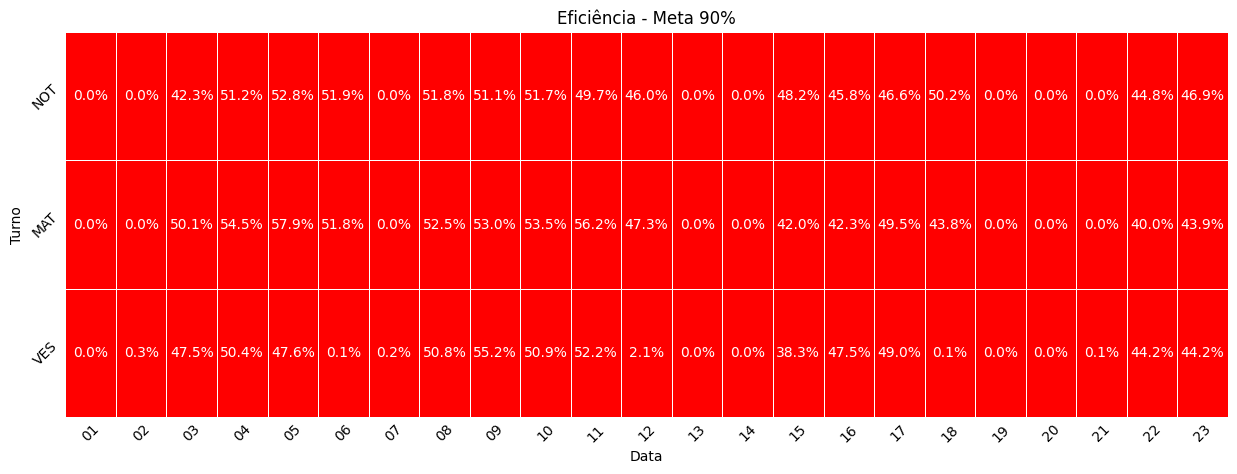

In [67]:
graph_heatmap_eff(df_eff, 90)
test(df_eff, 90)

In [68]:
# cSpell: disable=invalid-name
def graph_heatmap_perf(dataframe: pd.DataFrame, meta: int):
    # Converter 'data_registro' para datetime e criar uma nova coluna 'data_turno'

    dataframe["data_registro"] = pd.to_datetime(dataframe["data_registro"])

    dataframe["data_turno"] = dataframe["data_registro"].dt.strftime(
        "%Y-%m-%d"
    )

    # Agrupar por 'data_turno' e 'turno' e calcular a média da eficiência

    df_grouped = (
        dataframe.groupby(["data_turno", "turno"])["performance"]
        .mean()
        .reset_index()
    )

    # Remodelar os dados para o formato de heatmap

    df_pivot = df_grouped.pivot(
        index="turno", columns="data_turno", values="performance"
    )

    # Reordenar o índice do DataFrame

    df_pivot = df_pivot.reindex(["NOT", "MAT", "VES"])

    # Definir as cores baseado na eficiência

    colors = ["green", "green", "red", "red"]

    vmin, vmax = 0, 1  # Definir o intervalo de cores de 0 a 1

    norm = plt.Normalize(vmin, vmax)

    nodes = [
        vmin,
        0.04,
        0.041,
        vmax,
    ]  # Definir o ponto de mudança de cor para 4%

    cmap = mcolors.LinearSegmentedColormap.from_list(
        "", list(zip(nodes, colors))
    )

    # Criar o gráfico de calor

    plt.figure(figsize=(15, 5))

    sns.heatmap(
        df_pivot,
        cmap=cmap,
        norm=norm,
        linewidths=0.5,
        annot=True,
        fmt=".1%",
        cbar=False,
    )

    plt.title(f"Performance - Meta {meta}%")

    plt.xlabel("Data")

    plt.ylabel("Turno")

    # Definir os rótulos do eixo x para os dias e rotacionar 45 graus

    days = [date[-2:] for date in df_pivot.columns]

    plt.xticks(ticks=plt.xticks()[0], labels=days, rotation=45)

    # Rotacionar os rótulos do eixo y

    plt.yticks(rotation=45)

    # Remover os ticks dos eixos x e y

    plt.gca().tick_params(axis="both", which="both", length=0)

    plt.show()

In [69]:
# cSpell: disable=invalid-name
def graph_heatmap_perf_v2(dataframe: pd.DataFrame, meta: int):
    # Converter 'data_registro' para datetime e criar uma nova coluna 'data_turno'

    dataframe["data_registro"] = pd.to_datetime(dataframe["data_registro"])

    dataframe["data_turno"] = dataframe["data_registro"].dt.strftime(
        "%Y-%m-%d"
    )

    # Agrupar por 'data_turno' e 'turno' e calcular a média da eficiência

    df_grouped = (
        dataframe.groupby(["data_turno", "turno"])["performance"]
        .mean()
        .reset_index()
    )

    # Remodelar os dados para o formato de heatmap

    df_pivot = df_grouped.pivot(
        index="turno", columns="data_turno", values="performance"
    )

    # Reordenar o índice do DataFrame
    df_pivot = df_pivot.reindex(["VES", "MAT", "NOT"])

    # Criar escala de cores personalizada
    colors = [[0, "green"], [0.04, "green"], [0.04, "red"], [1, "red"]]

    # Extrair apenas o dia da data
    df_pivot.columns = pd.to_datetime(df_pivot.columns).day

    # Criar o gráfico de calor
    fig = go.Figure(
        data=go.Heatmap(
            z=df_pivot.values,
            x=df_pivot.columns,
            y=df_pivot.index,
            colorscale=colors,
            zmin=0,
            zmax=1,  # Escala de valores de 0 a 1
            hoverongaps=False,
            hovertemplate="Turno: %{y}<br>Dia: %{x}<br>Valor: %{z:.1%}",
            showscale=False,  # Não mostrar a escala de cores
            xgap=1,  # Espaçamento entre os dias
            ygap=1,  # Espaçamento entre os turnos
        )
    )

    # Adicionar anotações com a média da eficiência
    # pylint: disable=consider-using-enumerate
    for i in range(len(df_pivot.index)):
        for j in range(len(df_pivot.columns)):
            fig.add_annotation(
                x=df_pivot.columns[j],
                y=df_pivot.index[i],
                text=f"{df_pivot.values[i, j]:.1%}",
                showarrow=False,
                font=dict(color="white", size=8),
            )

    # Definir o título do gráfico
    fig.update_layout(
        title=f"Performance - Meta {meta}%",
        xaxis_title="Dia",
        yaxis_title="Turno",
        title_x=0.5,  # Centralizar o título
        xaxis_nticks=31,  # Definir o número de dias
        xaxis=dict(
            tickmode="linear",
            tickvals=list(range(1, 32)),  # Definir os dias
            ticktext=list(range(1, 32)),  # Definir os dias
            tickangle=45,  # Rotacionar os dias
        ),
        yaxis=dict(
            tickmode="linear",
            tickangle=45,
        ),
        plot_bgcolor="white",
        margin=dict(t=40, b=40, l=40, r=40),
    )

    fig.show()

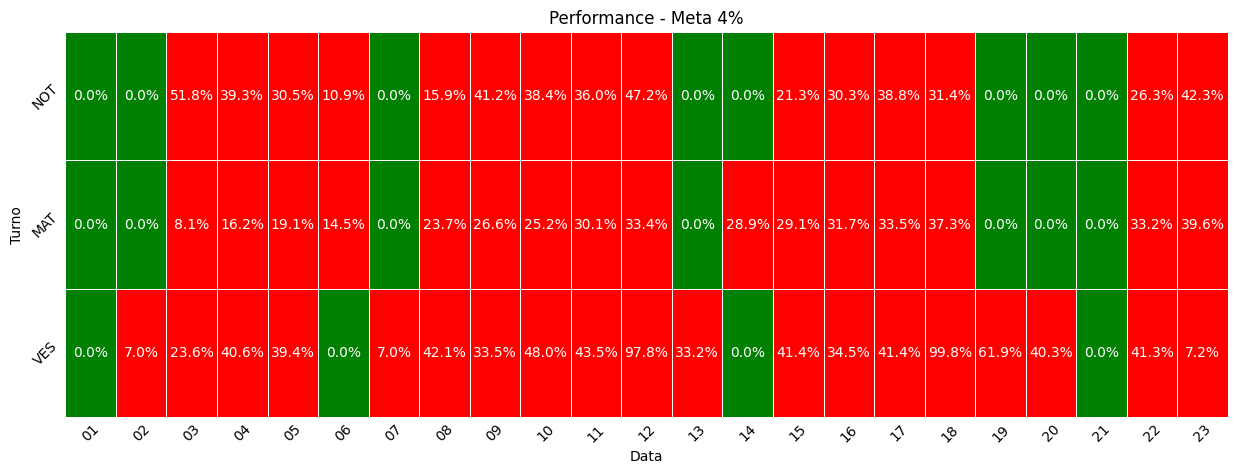

In [70]:
graph_heatmap_perf(df_perf.copy(), 4)
graph_heatmap_perf_v2(df_perf.copy(), 4)

In [71]:
# cSpell: disable=invalid-name
def graph_heatmap_reparos(dataframe: pd.DataFrame, meta: int):
    # Converter 'data_registro' para datetime e criar uma nova coluna 'data_turno'

    dataframe["data_registro"] = pd.to_datetime(dataframe["data_registro"])

    dataframe["data_turno"] = dataframe["data_registro"].dt.strftime(
        "%Y-%m-%d"
    )

    # Agrupar por 'data_turno' e 'turno' e calcular a média da eficiência

    df_grouped = (
        dataframe.groupby(["data_turno", "turno"])["reparo"]
        .mean()
        .reset_index()
    )

    # Remodelar os dados para o formato de heatmap

    df_pivot = df_grouped.pivot(
        index="turno", columns="data_turno", values="reparo"
    )

    # Reordenar o índice do DataFrame
    df_pivot = df_pivot.reindex(["VES", "MAT", "NOT"])

    # Criar escala de cores personalizada
    colors = [[0, "green"], [0.04, "green"], [0.04, "red"], [1, "red"]]

    # Extrair apenas o dia da data
    df_pivot.columns = pd.to_datetime(df_pivot.columns).day

    # Criar o gráfico de calor
    fig = go.Figure(
        data=go.Heatmap(
            z=df_pivot.values,
            x=df_pivot.columns,
            y=df_pivot.index,
            colorscale=colors,
            zmin=0,
            zmax=1,  # Escala de valores de 0 a 1
            hoverongaps=False,
            hovertemplate="Turno: %{y}<br>Dia: %{x}<br>Valor: %{z:.1%}",
            showscale=False,  # Não mostrar a escala de cores
            xgap=1,  # Espaçamento entre os dias
            ygap=1,  # Espaçamento entre os turnos
        )
    )

    # Adicionar anotações com a média da eficiência
    # pylint: disable=consider-using-enumerate
    for i in range(len(df_pivot.index)):
        for j in range(len(df_pivot.columns)):
            fig.add_annotation(
                x=df_pivot.columns[j],
                y=df_pivot.index[i],
                text=f"{df_pivot.values[i, j]:.1%}",
                showarrow=False,
                font=dict(color="white", size=8),
            )

    # Definir o título do gráfico
    fig.update_layout(
        title=f"Performance - Meta {meta}%",
        xaxis_title="Dia",
        yaxis_title="Turno",
        title_x=0.5,  # Centralizar o título
        xaxis_nticks=31,  # Definir o número de dias
        xaxis=dict(
            tickmode="linear",
            tickvals=list(range(1, 32)),  # Definir os dias
            ticktext=list(range(1, 32)),  # Definir os dias
            tickangle=45,  # Rotacionar os dias
        ),
        yaxis=dict(
            tickmode="linear",
            tickangle=45,
        ),
        plot_bgcolor="white",
        margin=dict(t=40, b=40, l=40, r=40),
    )

    fig.show()


reparos_map = graph_heatmap_reparos(df_reparos, 4)

# Encontrar a média de eficiência do período


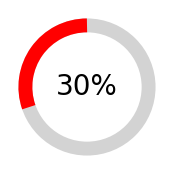

In [72]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# cSpell: disable=invalid-name


def draw_circular_progress_bar(percentage):
    fig, ax = plt.subplots(figsize=(2, 2))

    # Desenhar o círculo de progresso
    bg_circle = patches.Circle(
        (0.5, 0.5), 0.4, edgecolor="lightgray", facecolor="white", lw=10
    )
    ax.add_patch(bg_circle)

    # Definir a cor com base na porcentagem
    color = "green" if percentage >= 0.9 else "red"

    progress_arc = patches.Arc(
        (0.5, 0.5),
        0.8,
        0.8,
        angle=90,
        theta1=0,
        theta2=percentage * 360,
        color=color,
        lw=10,
    )
    ax.add_patch(progress_arc)

    # Adicionar o valor da porcentagem no centro
    ax.text(
        0.5,
        0.5,
        f"{percentage * 100:.0f}%",
        ha="center",
        va="center",
        fontsize=20,
    )

    # Remover os eixos
    ax.axis("off")
    ax.set_aspect("equal")

    plt.show()


# Testar a função
draw_circular_progress_bar(df_eff["eficiencia"].mean())  # 75%

In [73]:
import plotly.graph_objects as go

# cSpell: disable=invalid-name


def calculate_eficiencia(df):
    return df["eficiencia"].mean()


def calculate_performance(df):
    return df["performance"].mean()


def calculate_reparos(df):
    return df["reparo"].mean()


def draw_circular_progress_bar_v2(df: pd.DataFrame, type: str, meta: int):
    # mapear o tipo das funções
    type_map = {
        "eficiencia": calculate_eficiencia,
        "performance": calculate_performance,
        "reparo": calculate_reparos,
    }

    # Verificar a primeira data_registro do dataframe para saber se os dados são do mês atual
    this_month = df["data_registro"].iloc[0].month == pd.Timestamp.now().month
    month = "Atual" if this_month else "Anterior"

    # Obter a função com base no tipo
    func = type_map[type]

    # Calcular a porcentagem
    percentage = func(df.copy()) if func is not None else 0

    # Arredondar porcentagem para não ter casas decimais
    percentage = round(percentage, 2)

    # Definir a cor com base na porcentagem
    if type == "eficiencia":
        color = "green" if percentage >= (meta / 100) else "red"
    else:
        color = "red" if percentage >= (meta / 100) else "green"

    # Definir a escala do eixo para "performance" e "reparo"
    axis_range = [0, 100] if type == "eficiencia" else [100, 0]

    # Criar o gráfico
    fig = go.Figure(
        go.Indicator(
            mode="gauge+number",
            value=percentage * 100,
            number={"suffix": "%"},
            domain={"x": [0, 1], "y": [0, 1]},
            title={
                "text": month,
                "font": {"size": 14},
            },
            gauge={
                "axis": {
                    "range": axis_range,
                    "tickfont": {"size": 8},
                },
                "bar": {"color": color},
                "steps": [
                    {"range": [0, 100], "color": "lightgray"},
                ],
                "threshold": {
                    "line": {"color": "black", "width": 4},
                    "thickness": 0.75,
                    "value": meta,
                },
            },
        )
    )

    fig.update_layout(
        autosize=True,
        margin=dict(t=30, b=30, l=30, r=30),
        plot_bgcolor="white",
        width=200,  # apenas para visualização no jupyter
        height=200,  # apenas para visualização no jupyter
    )

    fig.show()


draw_circular_progress_bar_v2(df_eff, "eficiencia", 90)
draw_circular_progress_bar_v2(df_perf, "performance", 4)
draw_circular_progress_bar_v2(df_reparos, "reparo", 4)

# Gráfico de linhas


In [74]:
# cSpell: disable=invalid-name
def line_graph(df: pd.DataFrame, indicator: str):
    # Converter 'data_registro' para datetime e criar uma nova coluna 'data_turno'

    df["data_registro"] = pd.to_datetime(df["data_registro"])

    df["data_turno"] = df["data_registro"].dt.strftime("%Y-%m-%d")

    # Agrupar por 'data_turno' e 'turno' e calcular a média da eficiência

    df_grouped = df.groupby(["data_turno"])[indicator].mean().reset_index()

    # Multiplicar a eficiência por 100 para converter para porcentagem

    df_grouped[indicator] = df_grouped[indicator] * 100

    # Criar o gráfico

    fig = go.Figure(
        go.Scatter(
            x=df_grouped["data_turno"],
            y=df_grouped[indicator],
            mode="lines+markers",
            line=dict(color="blue"),
            marker=dict(color="blue"),
            hovertemplate="<i>Dia</i>: %{x}"
            + "<br><b>Porcentagem</b>: %{y:.1f}<br>",
            hoverinfo="skip",
        )
    )

    fig.update_layout(
        showlegend=False,
        plot_bgcolor="white",
        xaxis=dict(showticklabels=False),  # Esconde os valores do eixo x
        yaxis=dict(showticklabels=False),
        margin=dict(t=0, b=0, l=0, r=0),
        # height=None, # removido apenas para visualização no jupyter
        # autosize=True, # removido apenas para visualização no jupyter
        height=200,  # apenas para visualização no jupyter
    )

    fig.show()


line_graph(df_eff, "eficiencia")


line_graph(df_perf, "performance")


line_graph(df_reparos, "reparo")

## Gráficos por turno


In [152]:
# cSpell: words mcolors, eficiencia, vmin, vmax, cmap, figsize, linewidths, annot, cbar, xlabel,
# cSpell: words ylabel, xticks, yticks, colorscale, hoverongaps, zmin, zmax, showscale, xgap, ygap,
# cSpell: words nticks, tickmode, tickvals, ticktext, tickangle, lightgray, tickfont, showticklabels
# cSpell: words ndenumerate producao_total customdata xaxes


class IndicatorsTurn:
    """
    Esta classe é responsável por criar os gráficos de indicadores.
    """

    def __init__(self):
        self.danger_color = "#dc3545"
        self.warning_color = "#ffc107"
        self.success_color = "#198754"

    def get_eff_heat_turn(
        self,
        dataframe: pd.DataFrame,
        meta: int = 90,
        annotations: bool = False,
    ) -> go.Figure:
        """
        Este método é responsável por criar o gráfico de eficiência, por turno.

        Parâmetros:
        dataframe (pd.DataFrame): DataFrame contendo os dados para o gráfico.
                                Deve incluir as colunas 'data_registro', 'turno' e 'eficiencia'.
        meta (int): Meta de eficiência a ser alcançada. Padrão: 90.
        annotations (bool): Se True, adiciona anotações com a média da eficiência.

        Retorna:
        fig: Objeto plotly.graph_objects.Figure com o gráfico de eficiência.

        O gráfico é um heatmap que mostra a eficiência média por maquina e data.
        A eficiência é colorida de vermelho se estiver abaixo de 90% e
        de verde se estiver acima de 90%.
        """

        # Converter 'data_registro' para datetime e criar uma nova coluna 'data_turno'
        dataframe["data_registro"] = pd.to_datetime(dataframe["data_registro"])
        dataframe["data_turno"] = dataframe["data_registro"].dt.strftime(
            "%Y-%m-%d"
        )

        # Agrupar por 'data_turno' e 'turno' e calcular a média da eficiência
        df_grouped = (
            dataframe.groupby(["data_turno", "linha"])["eficiencia"]
            .mean()
            .reset_index()
        )

        # Ordenar por linha e data
        df_grouped = df_grouped.sort_values(
            ["linha", "data_turno"], ascending=[True, True]
        )

        # Remodelar os dados para o formato de heatmap
        df_pivot = df_grouped.pivot(
            index="linha", columns="data_turno", values="eficiencia"
        )

        # Criar escala de cores personalizada - cores do bootstrap
        colors = [
            [0, self.danger_color],
            [0.9, self.danger_color],
            [0.9, self.success_color],
            [1, self.success_color],
        ]

        # Extrair apenas o dia da data
        df_pivot.columns = pd.to_datetime(df_pivot.columns).day

        num_cells = len(df_pivot.index) * len(df_pivot.columns)
        font_size = 3000 / num_cells

        # Criar o gráfico de calor
        fig = go.Figure(
            data=go.Heatmap(
                z=df_pivot.values,
                x=df_pivot.columns,
                y=df_pivot.index,
                colorscale=colors,
                zmin=0,
                zmax=1,  # Escala de valores de 0 a 1
                hoverongaps=False,
                hovertemplate="Linha: %{y}<br>Dia: %{x}<br>Eficiência: %{z:.1%}",
                showscale=False,  # Não mostrar a escala de cores
                xgap=1,  # Espaçamento entre os dias
                ygap=1,  # Espaçamento entre os turnos
            )
        )

        # Adicionar anotações com a média da eficiência
        if annotations:
            for (i, j), value in np.ndenumerate(df_pivot.values):
                fig.add_annotation(
                    x=df_pivot.columns[j],
                    y=df_pivot.index[i],
                    text=f"{value:.1%}",
                    showarrow=False,
                    font=dict(color="white", size=font_size),
                )

        # Definir o título do gráfico
        fig.update_layout(
            title=f"Eficiência - Meta {meta}%",
            xaxis_title="Dia",
            yaxis_title="Linha",
            title_x=0.5,  # Centralizar o título
            xaxis_nticks=31,  # Definir o número de dias
            xaxis=dict(
                tickmode="linear",
                tickvals=list(range(1, 32)),  # Definir os dias
                ticktext=list(range(1, 32)),  # Definir os dias
                tickangle=45,  # Rotacionar os dias
            ),
            yaxis=dict(
                tickmode="linear",
                tickangle=45,
            ),
            plot_bgcolor="white",
            margin=dict(t=40, b=40, l=40, r=40),
        )

        fig.show()

        return fig

    def get_eff_bar_turn(
        self, dataframe: pd.DataFrame, meta: int = 90
    ) -> go.Figure:
        # Agrupar por 'turno' e "linha" e calcular a média da eficiência e soma da produção
        df_grouped = (
            dataframe.groupby(["linha", "turno"])
            .agg({"eficiencia": "mean", "producao_total": "sum"})
            .reset_index()
        )

        # Ajustar produção total para caixas, dividindo por 10
        df_grouped["producao_total"] = (
            df_grouped["producao_total"] / 10
        ).round(0)

        # Gráfico de barras
        fig = px.bar(
            df_grouped,
            orientation="h",
            x="eficiencia",
            y="linha",
            color="turno",
            barmode="group",
            hover_data={
                "producao_total": True,
                "linha": False,
                "eficiencia": False,
            },
            color_discrete_map={
                "NOT": self.danger_color,
                "MAT": self.warning_color,
                "VES": self.success_color,
            },
            labels={"eficiencia": "Eficiência"},
        )

        # Ajustar hover
        fig.update_traces(
            hovertemplate="<b>Linha</b>: %{y}<br><b>Eficiência</b>: %{x:.1%}<br><b>Produção</b>: %{customdata[0]} caixas<br>",
        )

        # Editar texto da legenda
        fig.for_each_trace(
            lambda trace: trace.update(
                name="Turno " + trace.name
                if trace.name in ["NOT", "MAT", "VES"]
                else trace.name
            )
        )

        # Definir o título do gráfico
        fig.update_layout(
            title="Eficiência por Linhas",
            xaxis_title="Eficiência",
            yaxis_title="Linha",
            legend=dict(
                title_text="Turno",
            ),
        )

        # Ajustar valores de x para porcentagem
        fig.update_xaxes(tickformat=".0%")

        # Calcular a média geral de eficiência
        avg_efficiency = df_grouped["eficiencia"].mean()

        # Adicionar linha de média geral
        fig.add_trace(
            go.Scatter(
                x=[avg_efficiency] * len(df_grouped["linha"]),
                y=df_grouped["linha"],
                mode="lines",
                name="Média Geral",
                line=dict(dash="dash", color="black"),
                hovertemplate="<b>Média Geral</b>: %{x:.1%}<br>",
            )
        )

        # Adicionar linha de meta
        fig.add_trace(
            go.Scatter(
                x=[meta / 100] * len(df_grouped["linha"]),
                y=df_grouped["linha"],
                mode="lines",
                name="Meta",
                line=dict(dash="dash", color="red"),
                hovertemplate="<b>Meta</b>: %{x:.1%}<br>",
            )
        )

        return fig


indicators_turn = IndicatorsTurn()

In [153]:
indicators_turn.get_eff_heat_turn(
    (df_eff[df_eff["turno"] == "MAT"]).copy(), 90, False
)

indicators_turn.get_eff_bar_turn(df_eff.copy())